# Loan Approval Prediction: Modular ML Pipeline
This notebook demonstrates a robust, modular pipeline for loan approval prediction using advanced machine learning models, feature engineering, and ensemble techniques. The workflow includes EDA, baseline models, advanced models, CatBoost, Optuna hyperparameter tuning, stacking, and submission generation.

---
## 1. Import Libraries and Data

In [ ]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay

# CatBoost and Optuna
from catboost import CatBoostClassifier, Pool, cv
import optuna
from tqdm.notebook import tqdm

# Set random seed for reproducibility
RSEED = 42
np.random.seed(RSEED)

In [2]:
# Import data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

---
## 2. Exploratory Data Analysis (EDA)
This section explores the data, visualizes distributions, checks for missing values, and investigates feature relationships with the target.

In [ ]:
# 1. Check for missing values
print("Missing values in each column:")
print(df_train.isnull().sum())

# 2. Target variable distribution
sns.countplot(x='loan_status', data=df_train)
plt.title('Target Variable Distribution')
plt.show()

# 3. Univariate analysis for numerical features
print("\nNumerical features summary:")
print(df_train.describe())

# 4. Univariate analysis for categorical features
print("\nCategorical features unique counts:")
print(df_train.select_dtypes(include='object').nunique())

# 5. Bivariate analysis: Numerical features vs. target
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.drop(['id', 'loan_status'])
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='loan_status', y=col, data=df_train)
    plt.title(f'{col} vs. loan_status')
    plt.show()

# 6. Bivariate analysis: Categorical features vs. target
cat_cols = df_train.select_dtypes(include='object').columns
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='loan_status', data=df_train)
    plt.title(f'{col} by loan_status')
    plt.xticks(rotation=45)
    plt.show()

# 7. Correlation matrix for numerical features
corr = df_train.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 8. Outlier detection for numerical features
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df_train[col])
    plt.title(f'Outlier check: {col}')
    plt.show()

# 9. Feature engineering opportunity: Age binning
bins = [18, 25, 35, 50, 100]
labels = ['18-25', '26-35', '36-50', '50+']
df_train['age_bin'] = pd.cut(df_train['person_age'], bins=bins, labels=labels)
print("\nLoan approval rate by age group:")
print(df_train.groupby('age_bin')['loan_status'].mean())

---
## 3. Baseline Model: Linear Regression
This section fits a simple linear regression model using only numerical features as a baseline for comparison.

Numerical Features Only Linear Regression Accuracy: 0.8814
Numerical Features Only Linear Regression ROC AUC: 0.8637


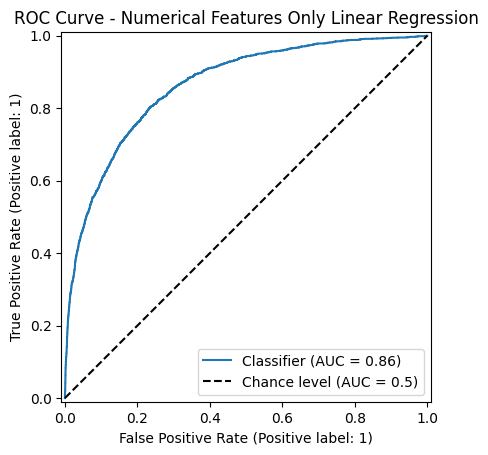

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Use only numerical features (excluding id and target)
numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.drop(['id', 'loan_status'])
X_num = df_train[numeric_cols]
y = df_train['loan_status']

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X_num, y, test_size=0.2, random_state=42)

# Fit linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr_model.predict(X_val)
y_pred_class = (y_pred > 0.5).astype(int)

# Evaluate performance
acc = accuracy_score(y_val, y_pred_class)
rocauc = roc_auc_score(y_val, y_pred)
print(f'Linear Regression - Accuracy: {acc:.4f}, ROC AUC: {rocauc:.4f}')

# Plot ROC curve
RocCurveDisplay.from_predictions(y_val, y_pred, plot_chance_level=True)
plt.title('ROC Curve - Linear Regression (Numerical Features)')
plt.show()

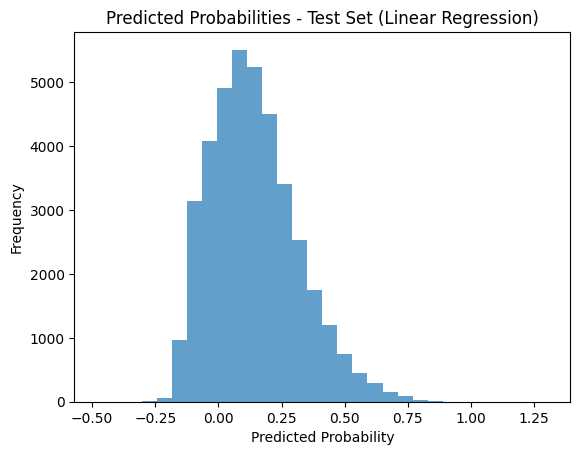

In [ ]:
# Test set predictions
X_test_lr = df_test[numeric_cols]
y_test_pred_lr = lr_model.predict(X_test_lr)

# Plot predicted probabilities distribution
plt.figure(figsize=(8,4))
plt.hist(y_test_pred_lr, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Test Set Predicted Probabilities - Linear Regression')
plt.show()

print(f'Test predictions range: {y_test_pred_lr.min():.3f} to {y_test_pred_lr.max():.3f}')

In [ ]:
# Create submission file for Linear Regression

# Load sample submission
sample_submission = pd.read_csv('data/sample_submission.csv')

# Assign predicted probabilities to the submission file
sample_submission['loan_status'] = y_test_pred_lr  

# Save to results folder
sample_submission.to_csv('results/submission_linear_regression.csv', index=False)
print('Linear Regression submission saved to results/submission_linear_regression.csv')

---
## 4. Advanced Model: CatBoost Classifier
This section trains a CatBoost model with cross-validation, handles categorical features, and generates a submission file.

In [ ]:
# Prepare data for CatBoost
cat_features = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
X = df_train.drop(['id', 'loan_status'], axis=1)
y = df_train['loan_status']
X_test = df_test.drop(['id'], axis=1)

# Ensure categorical columns are string type
for col in cat_features:
    X[col] = X[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Cross-validation with fixed parameters
cv_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': RSEED,
    'early_stopping_rounds': 50,
    'verbose': False
}

# Perform cross-validation
full_pool = Pool(X, y, cat_features=cat_features)
cv_results = cv(
    params=cv_params,
    pool=full_pool,
    fold_count=5,
    stratified=True,
    partition_random_seed=RSEED,
    plot=False
)
print(f'CatBoost 5-fold CV AUC: {cv_results["test-AUC-mean"].max():.4f}')

# Train final model
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RSEED)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
X_test_pool = Pool(X_test, cat_features=cat_features)

# Remove verbose from training params
train_params = cv_params.copy()
train_params.pop('verbose')

cat_model = CatBoostClassifier(**train_params, verbose=100)
cat_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

# Test predictions
y_test_pred_cat = cat_model.predict_proba(X_test_pool)[:, 1]

# Save submission
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission['loan_status'] = y_test_pred_cat
sample_submission.to_csv('results/submission_catboost.csv', index=False)
print('CatBoost submission saved to results/submission_catboost.csv')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9569187304
bestIteration = 835

Training on fold [1/5]

bestTest = 0.9569187304
bestIteration = 835

Training on fold [1/5]

bestTest = 0.9531236364
bestIteration = 970

Training on fold [2/5]

bestTest = 0.9531236364
bestIteration = 970

Training on fold [2/5]

bestTest = 0.952757533
bestIteration = 998

Training on fold [3/5]

bestTest = 0.952757533
bestIteration = 998

Training on fold [3/5]

bestTest = 0.9560828834
bestIteration = 957

Training on fold [4/5]

bestTest = 0.9560828834
bestIteration = 957

Training on fold [4/5]

bestTest = 0.9579826925
bestIteration = 999

CatBoost 5-fold CV best mean AUC: 0.9553236979664292

bestTest = 0.9579826925
bestIteration = 999

CatBoost 5-fold CV best mean AUC: 0.9553236979664292


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8911304	best: 0.8911304 (0)	total: 25ms	remaining: 25s
100:	test: 0.9391122	best: 0.9391122 (100)	total: 1.99s	remaining: 17.7s
100:	test: 0.9391122	best: 0.9391122 (100)	total: 1.99s	remaining: 17.7s
200:	test: 0.9448464	best: 0.9448464 (200)	total: 4.01s	remaining: 15.9s
200:	test: 0.9448464	best: 0.9448464 (200)	total: 4.01s	remaining: 15.9s
300:	test: 0.9493198	best: 0.9493230 (299)	total: 6.22s	remaining: 14.4s
300:	test: 0.9493198	best: 0.9493230 (299)	total: 6.22s	remaining: 14.4s
400:	test: 0.9523175	best: 0.9523175 (400)	total: 8.36s	remaining: 12.5s
400:	test: 0.9523175	best: 0.9523175 (400)	total: 8.36s	remaining: 12.5s
500:	test: 0.9545373	best: 0.9545373 (500)	total: 10.5s	remaining: 10.5s
500:	test: 0.9545373	best: 0.9545373 (500)	total: 10.5s	remaining: 10.5s
600:	test: 0.9558891	best: 0.9558945 (598)	total: 12.6s	remaining: 8.39s
600:	test: 0.9558891	best: 0.9558945 (598)	total: 12.6s	remaining: 8.39s
700:	test: 0.9567374	best: 0.9567374 (700)	total: 14.5s	re

---
## 5. Advanced CatBoost Stacking & Optuna Hyperparameter Tuning
This section implements out-of-fold stacking, baseline stacking, and Optuna-based hyperparameter optimization for CatBoost.

In [ ]:
# --- Advanced CatBoost Stacking with Baseline and Optuna Hyperparameter Tuning ---


# 1. Treat numerical features as both numeric and categorical
num_features = df_train.select_dtypes(include=['int64', 'float64']).columns.drop(['id', 'loan_status'])
cat_features = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
for col in num_features:
    df_train[f"{col}_cat"] = df_train[col].astype(str)
    df_test[f"{col}_cat"] = df_test[col].astype(str)
    cat_features.append(f"{col}_cat")
X = df_train.drop(['id', 'loan_status'], axis=1)
y = df_train['loan_status']
X_test = df_test.drop(['id'], axis=1)

# --- Optuna Hyperparameter Search for CatBoost ---

# Define Optuna objective function
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 500, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "border_count": trial.suggest_categorical("border_count", [64, 128, 254, 255]),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_strength": trial.suggest_float("random_strength", 1, 20),
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "cat_features": cat_features,
        "verbose": 0,
        "task_type": "CPU",
        "random_seed": 42,
        "thread_count": 6
    }
    
    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]
        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], early_stopping_rounds=50, verbose=0)
        y_pred = model.predict_proba(X_va)[:, 1]
        auc = roc_auc_score(y_va, y_pred)
        aucs.append(auc)
    return np.mean(aucs)

# Run Optuna optimization
study = optuna.create_study(direction="maximize", study_name="CatBoost_CV_AUC")
study.optimize(objective, n_trials=20, show_progress_bar=True)
print("Best parameters:", study.best_params)
print("Best CV ROC AUC:", study.best_value)

# 3. OOF predictions for stacking (CatBoost base)
def get_oof_predictions(model_class, model_params, X, y, X_test, n_splits=5, random_seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_train = np.zeros(X.shape[0])
    oof_test = np.zeros(X_test.shape[0])
    oof_test_skf = np.empty((n_splits, X_test.shape[0]))
    for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]
        model = model_class(**model_params)
        model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], early_stopping_rounds=50, verbose=0)
        oof_train[val_idx] = model.predict_proba(X_va)[:, 1]
        oof_test_skf[i, :] = model.predict_proba(X_test)[:, 1]
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train, oof_test

catboost_oof_params = study.best_params.copy()
catboost_oof_params.update({
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'cat_features': cat_features,
    'verbose': 0,
    'task_type': 'CPU',
    'random_seed': 42,
    'thread_count': 6
})
oof_train_cat, oof_test_cat = get_oof_predictions(
    CatBoostClassifier, catboost_oof_params, X, y, X_test, n_splits=5
)

def logit(p):
    p = np.clip(p, 1e-6, 1-1e-6)
    return np.log(p/(1-p))
# --- CatBoost stacking with baseline using best Optuna parameters (no retraining Optuna) ---

# Use the OOF baseline from previous cell
train_baseline = logit(oof_train_cat)
test_baseline = logit(oof_test_cat)

# Split training data for validation
X_train_stack, X_val_stack, y_train_stack, y_val_stack, train_baseline_split, val_baseline_split = train_test_split(
    X, y, train_baseline, test_size=0.2, random_state=42, stratify=y
)

train_pool = Pool(X_train_stack, y_train_stack, cat_features=cat_features, baseline=train_baseline_split)
val_pool = Pool(X_val_stack, y_val_stack, cat_features=cat_features, baseline=val_baseline_split)
test_pool = Pool(X_test, cat_features=cat_features, baseline=test_baseline)

stack_params = study.best_params.copy()
stack_params.update({
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'cat_features': cat_features,
    'verbose': 100,
    'task_type': 'CPU',
    'random_seed': 42,
    'thread_count': 6
})

# Train using validation set for eval_set (never test set)
cat_stack_model = CatBoostClassifier(**stack_params)
cat_stack_model.fit(
    train_pool,
    eval_set=val_pool,  # Only use validation pool with targets
    early_stopping_rounds=50,
    verbose=100
)

# Predict on test set
y_test_pred_stack = cat_stack_model.predict_proba(test_pool)[:, 1]

# Save submission
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission['loan_status'] = y_test_pred_stack
sample_submission.to_csv('results/submission_catboost_stack_baseline_optuna_v2.csv', index=False)
print('Stacked CatBoost (baseline) submission file saved to results/submission_catboost_stack_baseline_optuna_v2.csv')

In [ ]:
# --- Train Final CatBoost Model with Best Parameters ---

# Update best parameters for final model
final_params = study.best_params.copy()
final_params.update({
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'cat_features': cat_features,
    'verbose': 100,
    'task_type': 'CPU',
    'random_seed': 42,
    'thread_count': 6
})

# Train final model
final_catboost = CatBoostClassifier(**final_params)
final_catboost.fit(
    train_pool,
    eval_set=val_pool,
    early_stopping_rounds=50,
    verbose=100
)

# Predict on test set
y_test_pred_final = final_catboost.predict_proba(X_test_pool)[:, 1]

# Save submission
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission['loan_status'] = y_test_pred_final
sample_submission.to_csv('results/submission_catboost_optuna.csv', index=False)
print('Final CatBoost (Optuna) submission file saved to results/submission_catboost_optuna.csv')